## Automatic differentiation in TensorFlow

One of the major advantages of using deep learning frameworks like TensorFlow is the ability to automatically compute gradients of any differentiable operation. When using the Keras `model.fit` API, TensorFlow applies the backpropagation equations automatically to compute gradients, and then uses the optimiser algorithm selected to update the parameters.

In this notebook I use lower-level tools in TensorFlow to compute gradients of differentiable expressions instead, and build a custom training loop that breaks down the training loop to give extra flexibility and control.

In [1]:
import tensorflow as tf

Operations that we want to take gradients with respect to, need to be defined inside a `tf.GradientTape` context as Tape. Think of Tape as a Tape recorder which tracks all the functions and vairables! The Tape recoreder needs to be del after! 

#### Simple differentation

In [2]:
x = tf.constant(4.)

with tf.GradientTape() as Tape:
    
    #we want to track all operations on x. use tape.watch
    Tape.watch(x)
    
    #define function
    y = 4 * x ** 3 - x
    
#now lets calculate the derivative

dydx = Tape.gradient(y, x)
dydx

#lets confirm calculation dy/dx = 4*3*x**2 - 1 where x=4

<tf.Tensor: shape=(), dtype=float32, numpy=191.0>

#### Multiple derivatives

In [3]:
x = tf.constant([[1.,2.], [3.,4.]])
y= tf.constant([5., 6.])


with tf.GradientTape() as Tape:
    Tape.watch([x, y])
    
    # vairables in our function
    a = tf.constant(4.)
    
    #define function
    z = tf.reduce_mean(x**2, axis=0) * a + y 
    # x is (2,2). therefore reduce_mean will take the mean down axis z (row down dirn) making it at (1,2)!
    
dzdx, dzdy = Tape.gradient(z, [x,y])
print(dzdx, end=2*'\n')
print(dzdy)

#lets check calulation: dzdx = x*a (as 2's cancel) - remember its computed element-wise so will be same dim as x
                     #  dzdy = 1 (diff of y) - again elm wise so will be same dim as y 


tf.Tensor(
[[ 4.  8.]
 [12. 16.]], shape=(2, 2), dtype=float32)

tf.Tensor([1. 1.], shape=(2,), dtype=float32)


#### Multiple derivatives - persistant=True

In [4]:
x = tf.constant([[1.,2.], [3.,4.]])

#persistent=True in order to save multiple derivatives 
with tf.GradientTape(persistent=True) as Tape:
    Tape.watch(x)
    
    #define the vairables/functions used in function
    a = tf.random.normal((3,2))
    y = tf.math.sin(x)

    #define function
    z = tf.reduce_mean(tf.linalg.matmul(a, y), axis=0) # x is (2,2) therefore y is (2,2). a is (3,2) thus must be a @ y!
                                                       # a@y gives (3,2) reduce mean along axis 0 squashes to (1,2)
    
dzdx = Tape.gradient(z,x)
dzdy = Tape.gradient(z,y)

#MUST del Tape!
del Tape

print(dzdx, end=2*'\n')
print(dzdy, end=2*'\n')
print(z)

tf.Tensor(
[[-0.13580549  0.1045989 ]
 [-0.65929776 -0.43530208]], shape=(2, 2), dtype=float32)

tf.Tensor(
[[-0.25135094 -0.25135094]
 [ 0.6659624   0.6659624 ]], shape=(2, 2), dtype=float32)

tf.Tensor([-0.11752391 -0.73255473], shape=(2,), dtype=float32)


#### Gradients of a Layer

In [5]:
from tensorflow.keras.layers import Dense

x = tf.random.normal((1, 4))

#define layer 
dense_layer = Dense(1, activation='elu')

with tf.GradientTape() as tape:
    #tape automatically watches vairables and since x as is inputed into our model which creates 
    #weights and bias tf.variables and which we will diff w.r.t. We have no need to watch x
    
    # x is the input into dense layer
    y = dense_layer(x)
    
# diff layer w.r.t the layers vairables (weights and bias)
# note: Layer variables (as with any tf.variable) are automatically watched by the gradient tape - so no need to specify
grads = tape.gradient(y, dense_layer.trainable_variables) 
print(grads)

# weights have shape (imput_dim[-1], units)

[<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[-0.21923615],
       [ 0.28590745],
       [ 0.8140025 ],
       [ 0.03817137]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>]


#### Gradients of model operations

In [6]:
from tensorflow.keras.models import Sequential

model = Sequential([
    Dense(3, activation='sigmoid'),
    Dense(1, activation='linear')
])

x = tf.random.uniform((2, 2))
y = tf.random.uniform((2, 1))


with tf.GradientTape() as tape:
    
    #Define our function
    loss = tf.keras.losses.mse(y, model(x)) # model(x) is our prediction

#compute gradient of loss w.r.t model weights (as needed for GD optimisation)
grads = tape.gradient(loss, model.trainable_weights)
grads

#First layer has (2,3) weights differentials and (3,) bias differentials
#shows 2nd layer has (3, 1) weights differntials and (1,) bias diffential

[<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[-0.0421991 ,  0.06359334, -0.02707339],
        [-0.04672643,  0.06867856, -0.03089229]], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.06462037,  0.09497093, -0.04272681], dtype=float32)>,
 <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[-0.15277602],
        [-0.19152072],
        [-0.2664209 ]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.4032308], dtype=float32)>]

*Exercise.*

Use `tf.GradientTape` to make a plot of the function $\frac{dy}{dx}:[-5, 5]\mapsto\mathbb{R}$, where $y = \sin (x^2) - \frac{x^2}{4}$.

the way to do it would be to loop over a linspace the values (-5,5) and computing the gradinet for each - fairly simple to set

In [17]:
import numpy as np
import matplotlib.pyplot as plt

space = np.linspace(-5, 5, 100)

grads = []
for x in space:
    x = tf.constant(x)
    
    with tf.GradientTape() as Tape:
        #x is not a variable so have to watch it
        Tape.watch(x)
        
        #define the function
        y = tf.math.sin(x**2) - (x**2 / 4)
        
    dydx = Tape.gradient(y, x).numpy()
    grads.append(dydx)    

In [39]:
def y_line(x):
    return np.math.sin(x**2) - (x**2 / 4)

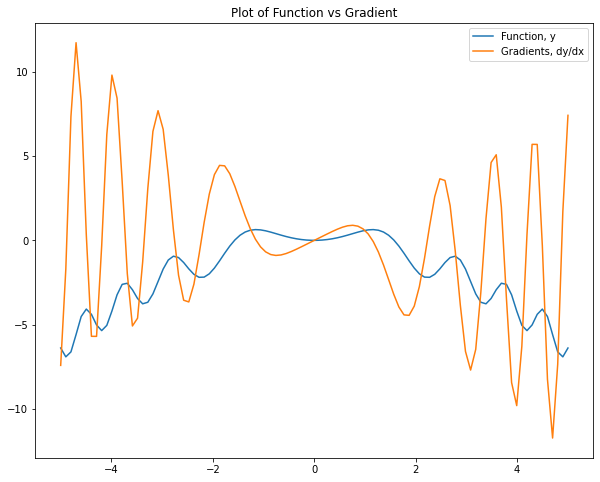

In [51]:
plt.figure(figsize=(10, 8))
plt.plot(space, [y_line(x) for x in space], label='Function, y')
plt.plot(space, grads, label='Gradients, dy/dx')
plt.title('Plot of Function vs Gradient')
plt.legend()
plt.show()

## Custom Training Loop: Low-Level Optimization

I am going to build a custom training loop which is used in the optimization of the parameters. Usually the Keras High-level API's `.fit` `.compile` are used. However I wanted to impliment a low-level equivelent, using GradientTape(). I will impliment the forward pass (computing the gradient of the loss w.r.t the model parameters) and backward pass/propogation (feeding these gradients back in to the NN and using an RSMprop optimizer to impliment the optimization). Used the MNIST dataset.

In [1]:
import tensorflow as tf

In [2]:
# Loading Fashion-MNIST dataset

(x_train, y_train), _ = tf.keras.datasets.fashion_mnist.load_data() 

In [3]:
# store class labels

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

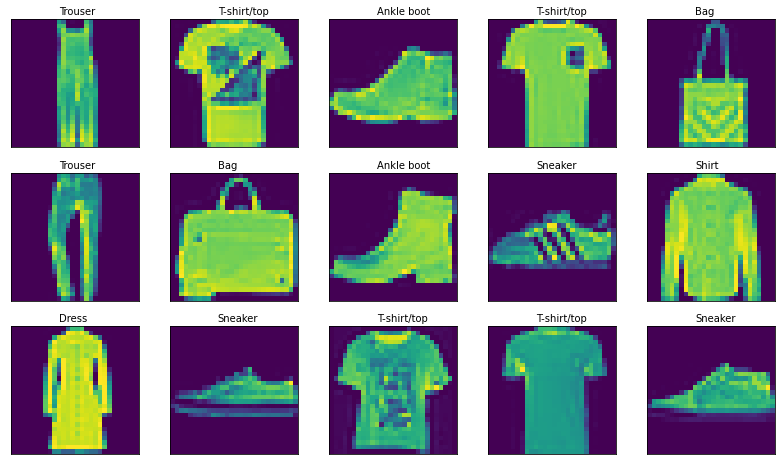

In [4]:
# View a few training data examples

import numpy as np
import matplotlib.pyplot as plt

n_rows, n_cols = 3, 5
random_inx = np.random.choice(x_train.shape[0], n_rows * n_cols, replace=False)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for n, i in enumerate(random_inx):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(x_train[i])
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -1.5, f'{classes[y_train[i]]}')
plt.show()

In [5]:
#create a Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense


def get_model():
    model = Sequential([
        Flatten(input_shape=(28,28)), # 28x28 is the image size ie 784 pixels 
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10) # 10 output catagories
    ], name='fashion_mnist_classifier')
    return model 

fashion_mnist_model = get_model()

In [6]:
# Model summary

fashion_mnist_model.summary()

Model: "fashion_mnist_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Define optimizer

rsmprop_opt = tf.keras.optimizers.RMSprop(learning_rate = 0.005)

#define loss function

spCC = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #data is sparse.
#the loss function is expecting the model to return the logits of the softmax rather than 
#the softmax output itself - works as i have no activation fun in last layer

In [8]:
# Load the data into a tf.data.Dataset

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset.element_spec

#each input is a (28,28) of type unit8 ie a interger between 0 and 254. Output is a scalar

(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [9]:
# Normalise the pixel values from (0,254) to (0,1).Easier for traning

def Normalise_pixels(image, label):
    return (tf.cast(image, tf.float32) / 255. , label)

train_dataset = train_dataset.map(Normalise_pixels)

In [10]:
# shuffle dataset

train_dataset = train_dataset.shuffle(buffer_size=1024)

In [11]:
#batch data 
batch_size = 64
train_dataset = train_dataset.batch(batch_size)

In [12]:
train_dataset.element_spec

(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [13]:
#Custom training loop!!

import time 

epochs = 5 
start = time.perf_counter()

for epoch in range(epochs):
    for images, labels in train_dataset:
        
        with tf.GradientTape() as Tape:
            
            #model predictions
            logits = fashion_mnist_model(images)
            #our batch_loss
            batch_loss = spCC(labels, logits)
            
        #FORWARD PASS - Gradients of the loss w.r.t model weights
        grads = Tape.gradient(batch_loss, fashion_mnist_model.trainable_weights)
            
        #BACKWARD PROPOGATION - use optimizers built in apply_gradient method to propogate back through NN
        rsmprop_opt.apply_gradients(zip(grads, fashion_mnist_model.trainable_weights))
            
    print("End of epoch {}, final loss value: {}".format(epoch, batch_loss))
print("End of training, time: {:.4f}".format(time.perf_counter() - start))     

End of epoch 0, final loss value: 0.6775978803634644
End of epoch 1, final loss value: 0.2938024401664734
End of epoch 2, final loss value: 0.6153756976127625
End of epoch 3, final loss value: 0.4032072424888611
End of epoch 4, final loss value: 0.3374311923980713
End of training, time: 58.1787


### Lets speed it us using TensorFlows built in optimization functions

Tensorflow has its own built-in optimizations which speed up the processing power. See here for more details: https://www.tensorflow.org/guide/data_performance.

I Optimise the custom training loop by compiling the training step into a graph! If tensor flow can see the whole compuational graph before anything is executed (where the @tf.function comes in) it can make optimisations itself - i.e it can run certain steps in parallel. In my first implimentation above, Tensorflow cannot see the whole computational graph - hence it cannot apply any optimisations and thus is much slower!

In [14]:
#compose the training step into a function.

@tf.function #<-- Python decorator
def train_step(images, labels):
    
    with tf.GradientTape() as Tape:
            
        #model predictions
        logits = fashion_mnist_model(images)
        #our batch_loss
        batch_loss = spCC(labels, logits)

    #FORWARD PASS - Gradients of the loss w.r.t model weights
    grads = Tape.gradient(batch_loss, fashion_mnist_model.trainable_weights)

    #BACKWARD PROPOGATION - use optimizers built in apply_gradient method to propogate back through NN
    rsmprop_opt.apply_gradients(zip(grads, fashion_mnist_model.trainable_weights))
    
    return batch_loss


# interate as before

import time 

epochs = 5 
start = time.perf_counter()

for epoch in range(epochs):
    for images, labels in train_dataset:
        
        with tf.GradientTape() as Tape:
            #model predictions
            logits = fashion_mnist_model(images) 
            
            # call the training step function we have defined
            batch_loss = train_step(images, labels)
         
    print("End of epoch {}, final loss value: {}".format(epoch, batch_loss))
print("End of training, time: {:.4f}".format(time.perf_counter() - start))

End of epoch 0, final loss value: 0.27868974208831787
End of epoch 1, final loss value: 0.38076573610305786
End of epoch 2, final loss value: 0.36072105169296265
End of epoch 3, final loss value: 0.20981484651565552
End of epoch 4, final loss value: 0.4553931653499603
End of training, time: 21.6718
